In [24]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
import joblib

In [25]:
data = pd.read_csv('emotion_dataset.csv')
print("✅ Dataset loaded successfully.")
print(data.head())

✅ Dataset loaded successfully.
                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [26]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)     # remove links
    text = re.sub(r'@\w+', '', text)        # remove mentions
    text = re.sub(r'#', '', text)           # keep hashtag words
    text = re.sub(r'[^a-z\s!?]', '', text)  # keep letters + ! ?
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data["text"] = data["text"].apply(preprocess_text)

In [27]:
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["label"])
print("\nEncoded Labels:", label_encoder.classes_)


Encoded Labels: ['anger' 'fear' 'love' 'sadness']


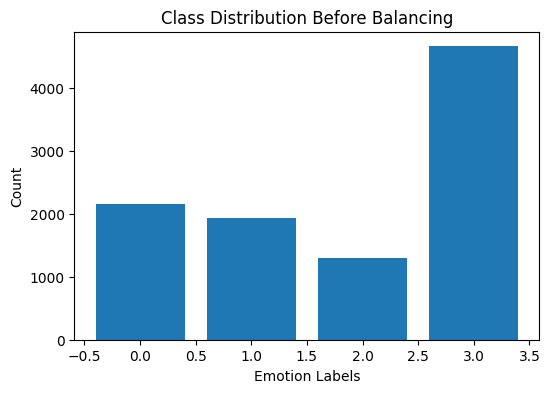

In [28]:
plt.figure(figsize=(6,4))
plt.bar(Counter(data["label"]).keys(), Counter(data["label"]).values())
plt.title("Class Distribution Before Balancing")
plt.xlabel("Emotion Labels")
plt.ylabel("Count")
plt.show()

In [29]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data["text"])

vocab_size = len(tokenizer.word_index) + 1
max_length = 100

X = tokenizer.texts_to_sequences(data["text"])
X = pad_sequences(X, maxlen=max_length, padding='post')
y = data["label"].values

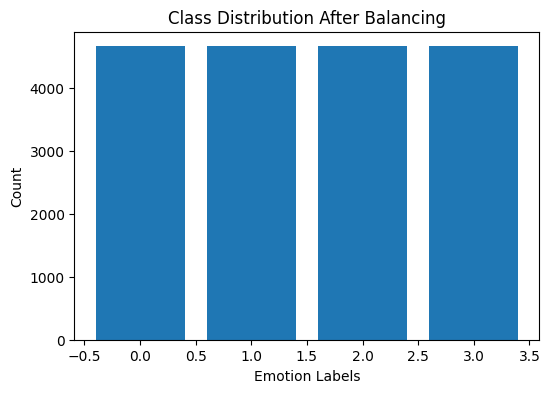

In [30]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

plt.figure(figsize=(6,4))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title("Class Distribution After Balancing")
plt.xlabel("Emotion Labels")
plt.ylabel("Count")
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [32]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

d:\AI_ASS\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[lr_scheduler],
    verbose=1
)


Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 127s 271ms/step - accuracy: 0.4983 - loss: 1.0100 - val_accuracy: 0.7791 - val_loss: 0.5407 - learning_rate: 5.0000e-04
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 111s 265ms/step - accuracy: 0.8494 - loss: 0.4050 - val_accuracy: 0.9250 - val_loss: 0.2857 - learning_rate: 5.0000e-04
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 113s 269ms/step - accuracy: 0.9393 - loss: 0.2132 - val_accuracy: 0.9511 - val_loss: 0.2016 - learning_rate: 5.0000e-04
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 115s 274ms/step - accuracy: 0.9627 - loss: 0.1372 - val_accuracy: 0.9558 - val_loss: 0.1839 - learning_rate: 5.0000e-04
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 115s 275ms/step - accuracy: 0.9759 - loss: 0.0909 - val_accuracy: 0.9645 - val_loss: 0.1455 - learning_rate: 5.0000e-04
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 118s 281ms/step - accuracy: 0.9822 - loss: 0.0664 - val_accuracy: 0.9618 - val_loss: 0.1523 - learning_rate: 5.0000e-04
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 

In [34]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed classification report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))




✅ Test Accuracy: 97.08%
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step

Classification Report:

              precision    recall  f1-score   support

       anger       0.97      0.96      0.97       950
        fear       0.96      0.98      0.97       947
        love       0.99      1.00      0.99       909
     sadness       0.96      0.94      0.95       927

    accuracy                           0.97      3733
   macro avg       0.97      0.97      0.97      3733
weighted avg       0.97      0.97      0.97      3733



In [35]:
model.save('emotion_detection_model.h5')
joblib.dump(tokenizer, 'tokenizer.jb')
joblib.dump(label_encoder, 'label_encoder.jb')
print("\n✅ Model, tokenizer, and label encoder saved successfully.")


✅ Model, tokenizer, and label encoder saved successfully.
